# Automating a medical image segmentation problem

In this lab you will be automating a real medical imaging problem.

You will be building a system for prostate gland segmentation on MR images. The dataset is provided [here](https://github.com/s-sd/EMS741/tree/main/tutorials/images).

With this data, there is a known problem, segmentation NNs do not do very well when the prostate gland is not present in the image i.e., they create false positives.

As such, you will need to build a system which:
1) classifies an image as prostate gland present vs absent
2) segment gland using a segmentation NN only if gland present

This will require two neural networks corresponding to the two tasks above. Your task in this lab is to build, train and evaluate (quantitatively and qualitatively) these two NNs using the given dataset.

Then you should write a function, which takes in an image and returns the segmentation if the gland is present, or returns a null value if the gland is absent.

Alternative (easier): Implement a segmentation network which does not have the first presence classification step i.e., it tries to segment the gland regardless of its presence in the image. Then quantify the false-positive rate on gland absent images.

### Download the dataset

In [1]:
!wget -O images_lab_data.zip https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip

--2026-02-20 11:33:34--  https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip [following]
--2026-02-20 11:33:35--  https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23924619 (23M) [application/zip]
Saving to: ‘images_lab_data.zip’

images_lab_data.zip 100%[===================>]  22.82M  --.-KB/s    in 0.08s   

2026-02-20 11:33:35 (277 MB/s) - ‘images_lab

In [2]:
import zipfile
import os

path_to_zip = r'images_lab_data.zip'
path_to_extract_to = r'./'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

In [3]:
!ls

# we are interested in 'images' and 'masks'

images	images_lab_data.zip  masks  sample_data


### Data checks

Before you proceed with building your segmentation system, load in a single image and corresponding mask to verify that they are paired correctly. And to check their shapes etc. Hint: use the matplotlib imread function.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import random

In [5]:
images = os.listdir('images')
masks = os.listdir('masks')

Selected Image: sample_546_slice_003.png, Selected Mask: sample_546_slice_003.png


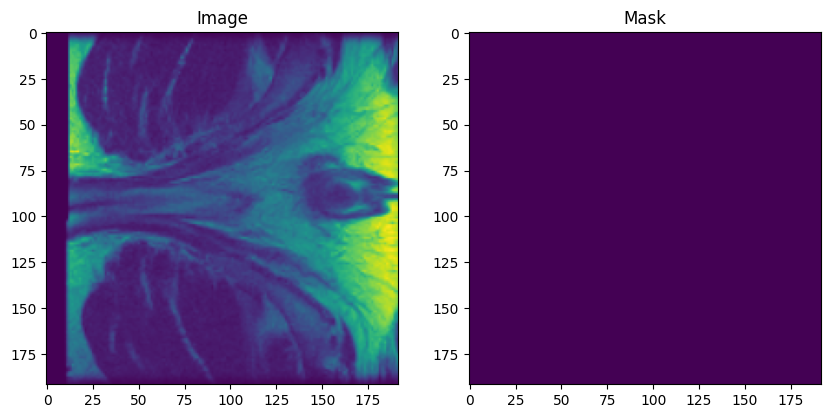

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img_mask_idx = random.randint(0, len(images) - 1)  # random index to select an image and its corresponding mask
print(f"Selected Image: {images[img_mask_idx]}, Selected Mask: {masks[img_mask_idx]}")
ax[0].imshow(plt.imread('images/' + images[img_mask_idx]))
ax[0].set_title('Image')
ax[1].imshow(plt.imread('masks/' + masks[img_mask_idx]))
ax[1].set_title('Mask')
plt.show()

### Your segmentation approach

Now it's time to build your segmentation system

In [7]:
assert len(images) == len(masks), "The number of images and masks should be the same."

In [8]:
# import all the required libraries
import os  # for basic file operations
import numpy as np  # to deal with arrays (and images)
import tensorflow as tf  # to build the model
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt  # to make required plots
from sklearn.model_selection import train_test_split  # to split the data into train/test/validation
from sklearn.metrics import classification_report, confusion_matrix  # to get the evaluation metrics
import cv2  # for image related operations
from pathlib import Path

In [9]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
class DataLoader:
    def __init__(
        self, images_dir='images', masks_dir='masks',
        # keeping the default image dimensions as 128x128. this can change while instantiating the class object
        img_size=(128, 128)
    ):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.img_size = img_size

    def load_data(self):
        images = []
        masks = []
        labels = []  # 1 if prostate present, 0 if absent
        filenames = []

        image_files = sorted(list(self.images_dir.glob('*.png')) +
                             list(self.images_dir.glob('*.jpg')))

        print(f"found {len(image_files)} images")

        for img_path in image_files:
            # loading the image and converting it to grayscale to reduce the number of channels
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0

            # load corresponding mask
            mask_path = self.masks_dir / img_path.name
            if mask_path.exists():
                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.img_size)
                mask = (mask > 127).astype(np.float32)  # Binary mask

                # label: 1 if prostate present (any white pixels), 0 otherwise
                label = 1 if np.sum(mask) > 0 else 0
            else:
                # if no mask, assume no prostate
                mask = np.zeros(self.img_size, dtype=np.float32)
                label = 0

            images.append(img)
            masks.append(mask)
            labels.append(label)
            filenames.append(img_path.name)

        images = np.array(images)[..., np.newaxis]  # Add channel dimension
        masks = np.array(masks)[..., np.newaxis]
        labels = np.array(labels)

        print(f"Loaded {len(images)} images")
        print(f"Positive samples (prostate present): {np.sum(labels)}")
        print(f"Negative samples (prostate absent): {len(labels) - np.sum(labels)}")

        return images, masks, labels, filenames

In [11]:
class ClassifierModel:
    def __init__(self, input_shape=(128, 128, 1), cutoff_threshold: float = 0.5):
        self.input_shape = input_shape
        self.cutoff_threshold = cutoff_threshold
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential([
            layers.Conv2D(
                32, (3, 3), activation='relu',
                padding='same', input_shape=self.input_shape
            ),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),  # adding dropout later to handle overfitting
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.2),  # adding dropout layer to handle overfitting
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            # using sigmoid in the lasty layer for binary classification
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            # using adam optimizer since it enables adaptive learning rate
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(),
                     tf.keras.metrics.Recall()]
        )

        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        # handle class imbalance
        class_weight = None
        if len(y_train) > 0:
            neg_count = np.sum(y_train == 0)
            pos_count = np.sum(y_train == 1)
            if pos_count > 0 and neg_count > 0:
                class_weight = {
                    0: len(y_train) / (2 * neg_count),
                    1: len(y_train) / (2 * pos_count)
                }

        # adding an earlystop check to stop the training process when we attain a certain level of accuracy during training
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, images):
        """Predict if prostate is present"""
        probs = self.model.predict(images, verbose=0)
        return (probs > self.cutoff_threshold).astype(int).flatten()

In [12]:
class UNetModel:
    def __init__(self, input_shape=(128, 128, 1)):
        self.input_shape = input_shape
        self.model = self.build_model()

    def build_model(self):
        """build U-Net architecture"""
        inputs = layers.Input(shape=self.input_shape)

        # encoder (contracting path)
        c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
        p1 = layers.MaxPooling2D((2, 2))(c1)
        c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
        p2 = layers.MaxPooling2D((2, 2))(c2)
        c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
        p3 = layers.MaxPooling2D((2, 2))(c3)
        c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

        # decoder (expansive path)
        u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
        u5 = layers.concatenate([u5, c3])
        c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
        c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
        u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
        u6 = layers.concatenate([u6, c2])
        c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
        u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
        u7 = layers.concatenate([u7, c1])
        c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

        # output
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
        model = models.Model(inputs=[inputs], outputs=[outputs])

        # compiling the model with adam optimizer
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=[self.dice_coefficient]
        )

        return model

    @staticmethod
    def dice_coefficient(y_true, y_pred, smooth=1):
        # dice coefficient metric
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (
            tf.keras.backend.sum(y_true_f) +
            tf.keras.backend.sum(y_pred_f) + smooth
        )

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
        # train the U-Net
        # adding earlystopping to the training process
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
        ]

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, images, threshold=0.5):
        # Predict segmentation masks
        preds = self.model.predict(images, verbose=0)
        return (preds > threshold).astype(np.float32)

In [13]:
class ProstateSegmentationSystem:
    """
    combined system: Classifier + Segmentation
    """

    def __init__(self, cutoff_classification_threshold: float = 0.5):
        self.classifier = ClassifierModel()
        self.segmentor = UNetModel()
        self.cutoff_classification_threshold = cutoff_classification_threshold

    def predict_single_image(self, image, return_probability=False):
        """
        Main inference function: Takes an image, returns segmentation or None

        Args:
            image: Input image (H, W) or (H, W, 1) or (1, H, W, 1)
            return_probability: If True, also return classification probability

        Returns:
            segmentation mask if prostate present, None otherwise
            (optionally with classification probability)
        """
        # ensure correct shape
        if len(image.shape) == 2:
            image = image[..., np.newaxis]
        if len(image.shape) == 3:
            image = np.expand_dims(image, 0)

        # step 1: classify
        class_prob = self.classifier.model.predict(image, verbose=0)[0][0]
        is_present = class_prob > self.cutoff_classification_threshold

        # step 2: segment only if prostate is present
        if is_present:
            segmentation = self.segmentor.predict(image, threshold=0.5)[0]
            if return_probability:
                return segmentation, class_prob
            return segmentation
        else:
            if return_probability:
                return None, class_prob
            return None

    def save_models(self, classifier_path='classifier_weights.h5',
                    segmentor_path='segmentor_weights.h5'):
        """Save both model weights"""
        self.classifier.model.save_weights(classifier_path)
        self.segmentor.model.save_weights(segmentor_path)
        print(f"Models saved to {classifier_path} and {segmentor_path}")

In [14]:
def evaluate_classifier(classifier: ClassifierModel, X_test: np.array, y_test: np.array):
    # Evaluate classifier performance
    print("Classifier Evaluation")
    y_pred = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=['No Prostate', 'Prostate Present'])
    )

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return y_pred


def evaluate_segmentation(segmentor: UNetModel, X_test: np.array, y_test: np.array):
    # Evaluate segmentation performance
    print("Segmentation Evaluation")
    y_pred = segmentor.predict(X_test)

    dice_scores = []
    for i in range(len(y_test)):
        true_mask = y_test[i].flatten()
        pred_mask = y_pred[i].flatten()
        intersection = np.sum(true_mask * pred_mask)
        dice = (2 * intersection + 1) / (np.sum(true_mask) + np.sum(pred_mask) + 1)
        dice_scores.append(dice)

    print(
        f"Mean Dice Coefficient: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")

    return y_pred, dice_scores

In [15]:
# 1. load data
loader = DataLoader(images_dir='images', masks_dir='masks', img_size=(128, 128))
images, masks, labels, filenames = loader.load_data()

found 1037 images
Loaded 1037 images
Positive samples (prostate present): 826
Negative samples (prostate absent): 211


In [16]:
# 2. split data
X_train, X_temp, y_masks_train, y_masks_temp, y_labels_train, y_labels_temp = \
    train_test_split(images, masks, labels, test_size=0.3, random_state=42, stratify=labels)

X_val, X_test, y_masks_val, y_masks_test, y_labels_val, y_labels_test = \
    train_test_split(X_temp, y_masks_temp, y_labels_temp, test_size=0.5, 
                    random_state=42, stratify=y_labels_temp)

print(f"Train: {len(X_train)} (Positive: {np.sum(y_labels_train)} | Negative: {len(y_labels_train)-np.sum(y_labels_train)})")
print(f"Val: {len(X_val)} (Positive: {np.sum(y_labels_val)} | Negative: {len(y_labels_val)-np.sum(y_labels_val)})")
print(f"Test: {len(X_test)} (Positive: {np.sum(y_labels_test)} | Negative: {len(y_labels_test)-np.sum(y_labels_test)})")

Train: 725 (Positive: 577 | Negative: 148)
Val: 156 (Positive: 125 | Negative: 31)
Test: 156 (Positive: 124 | Negative: 32)


In [17]:
# 3. train classifier
# make sure to use GPU as the runtime to make the training process faster
cutoff_classification_threshold = 0.5
classifier = ClassifierModel(
    input_shape=(128, 128, 1),
    cutoff_threshold=cutoff_classification_threshold
)
classifier_history = classifier.train(
    X_train, y_labels_train,
    X_val, y_labels_val,
    epochs=50,
    batch_size=32  # this is usually set in a multiple of 8
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - accuracy: 0.5875 - loss: 0.7925 - precision: 0.8158 - recall: 0.6384 - val_accuracy: 0.1987 - val_loss: 0.6952 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5606 - loss: 0.6683 - precision: 0.8377 - recall: 0.5723 - val_accuracy: 0.4167 - val_loss: 0.6990 - val_precision: 1.0000 - val_recall: 0.2720
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5952 - loss: 0.6349 - precision: 0.8689 - recall: 0.5821 - val_accuracy: 0.8013 - val_loss: 0.4850 - val_precision: 0.9123 - val_recall: 0.8320
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7828 - loss: 0.5296 - precision: 0.9245 - recall: 0.7975 - val_accuracy: 0.8718 - val_loss: 0.3459 - val_precision: 0.9134 - val_recall: 0.9280
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8065 - loss: 0.4231 - precision: 0.9244 - recall: 0.8297 - val_accuracy: 0.8910 - val_los

In [18]:
# 4. train u-net (only on positive samples)
# training only on positive samples because we don't want to train the
# segmentation model about "nothing" in the input image. the images with
# no gland will be handled by the classifier itself.
pos_train_idx = y_labels_train == 1
pos_val_idx = y_labels_val == 1

# again, make sure you've changed the runtime to GPU before training
segmentor = UNetModel(input_shape=(128, 128, 1))
segmentor_history = segmentor.train(
    X_train[pos_train_idx], y_masks_train[pos_train_idx],
    X_val[pos_val_idx], y_masks_val[pos_val_idx],
    epochs=50,
    batch_size=32
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 928ms/step - dice_coefficient: 0.0364 - loss: 0.4697 - val_dice_coefficient: 0.0125 - val_loss: 0.1385
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - dice_coefficient: 0.0224 - loss: 0.1303 - val_dice_coefficient: 0.0469 - val_loss: 0.1019
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - dice_coefficient: 0.0520 - loss: 0.1013 - val_dice_coefficient: 0.0787 - val_loss: 0.0867
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - dice_coefficient: 0.0988 - loss: 0.0855 - val_dice_coefficient: 0.1775 - val_loss: 0.0667
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - dice_coefficient: 0.2406 - loss: 0.0644 - val_dice_coefficient: 0.3147 - val_loss: 0.0561
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - dice_coefficient: 0.3906 - loss: 0.0505 - val_dice_coefficient: 0.4824 - val_loss: 0.0408
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - dice_coefficient: 0.5129 - loss: 0.0386 - val_dice_coefficient: 0.5920 - val_loss

In [19]:
# 5. evaluate models

# evaluate classifier
y_class_pred = evaluate_classifier(classifier, X_test, y_labels_test)

# evaluate segmentation (only on positive samples)
pos_test_idx = y_labels_test == 1
y_seg_pred, dice_scores = evaluate_segmentation(
    segmentor, X_test[pos_test_idx], y_masks_test[pos_test_idx]
)

Classifier Evaluation
Classification Report:
                  precision    recall  f1-score   support

     No Prostate       0.90      0.81      0.85        32
Prostate Present       0.95      0.98      0.96       124

        accuracy                           0.94       156
       macro avg       0.92      0.89      0.91       156
    weighted avg       0.94      0.94      0.94       156

Confusion Matrix:
[[ 26   6]
 [  3 121]]
Segmentation Evaluation
Mean Dice Coefficient: 0.8756 ± 0.1065


Image index 0: Prostate ABSENT (prob=0.000)
Image index 1: Prostate PRESENT (prob=0.997)
Image index 2: Prostate PRESENT (prob=0.976)
Image index 3: Prostate ABSENT (prob=0.000)
Image index 4: Prostate PRESENT (prob=0.999)


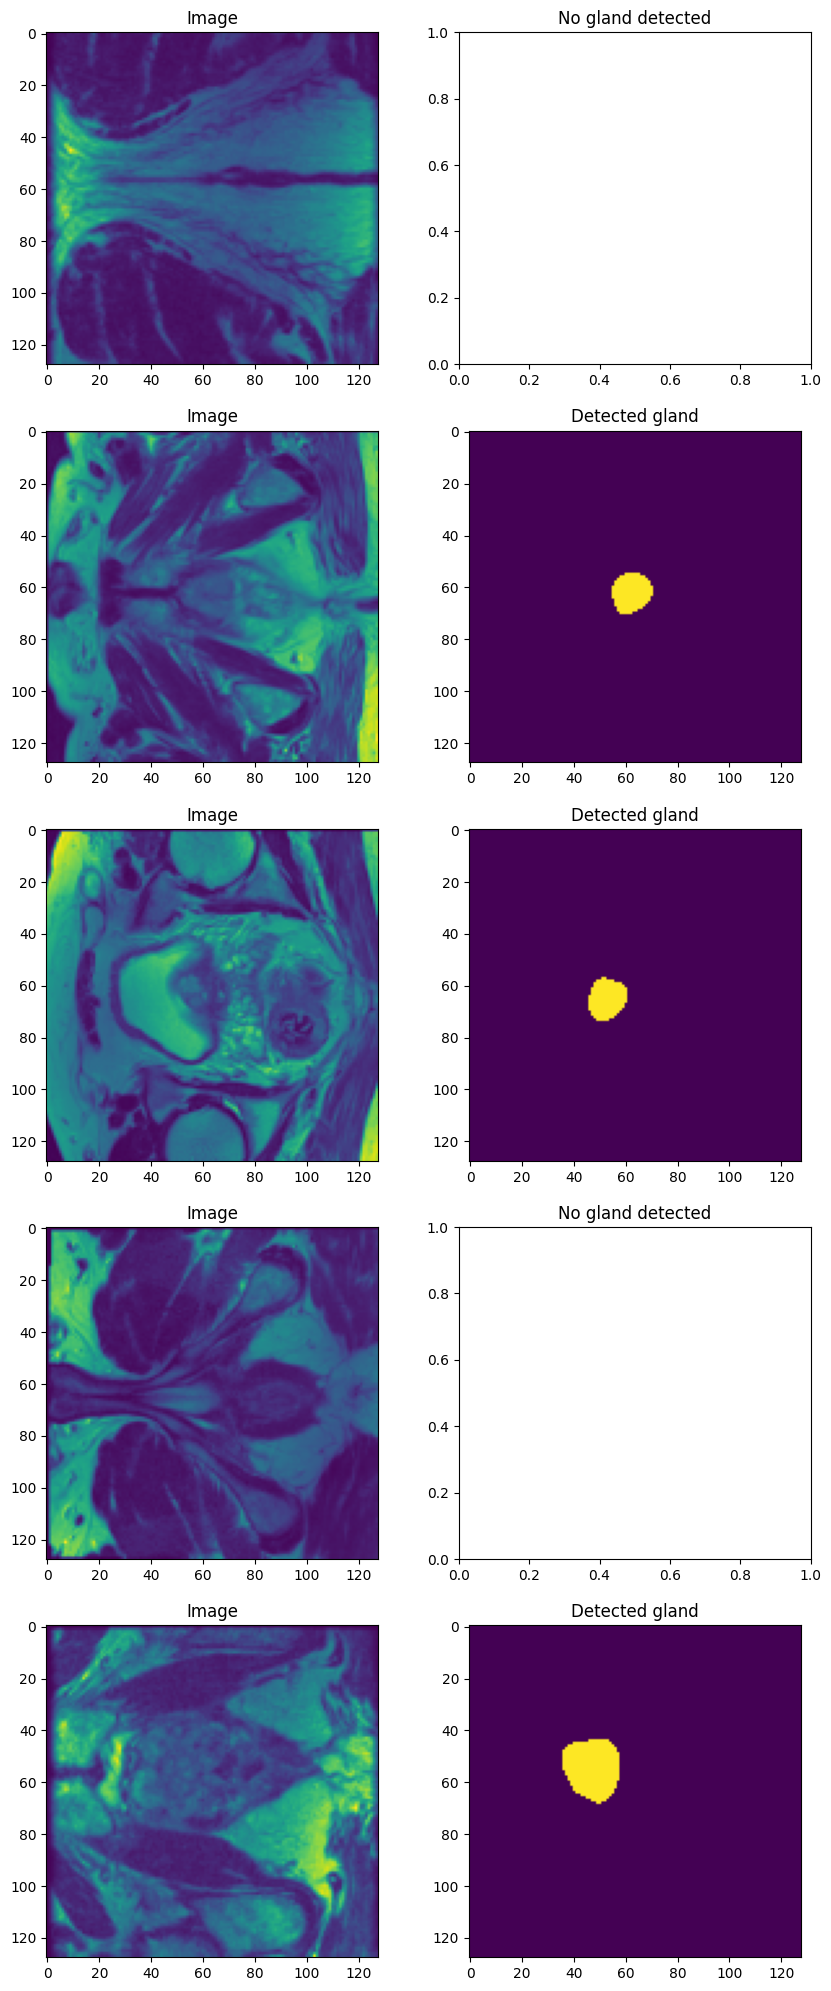

In [34]:
# testing the entire system
complete_pipeline = ProstateSegmentationSystem(
    cutoff_classification_threshold=cutoff_classification_threshold)
complete_pipeline.classifier = classifier
complete_pipeline.segmentor = segmentor

num_samples = 5
fig, ax = plt.subplots(num_samples, 2, figsize=(10, num_samples*5))

for i in range(num_samples):
    result = complete_pipeline.predict_single_image(
        X_test[i], return_probability=True)
    if result[0] is not None:
        seg, prob = result
        print(f"Image index {i}: Prostate PRESENT (prob={prob:.3f})")
    else:
        prob = result[1]
        print(f"Image index {i}: Prostate ABSENT (prob={prob:.3f})")
    ax[i, 0].imshow(X_test[i])
    ax[i, 0].set_title('Image')
    if result[0] is not None:
        ax[i, 1].imshow(seg)
        ax[i, 1].set_title('Detected gland')
    else:
        ax[i, 1].set_title('No gland detected')

plt.show()